### Рабочая версия

In [11]:
import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import Normal
from torch.distributions.categorical import Categorical
from torch.distributions import RelaxedOneHotCategorical
from torch.nn import KLDivLoss

# torch.manual_seed(42)

class SAC_discrete(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1.0, tau=0.5, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3, a_lr=1e-4, period=15):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim), nn.LogSoftmax(dim=1))
        self.pi_model.name = "policy"

        self.q1_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim))
        self.q1_model.name = "q1"

        self.q2_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim))
        self.q2_model.name = "q2"

        self.q1_layers_list = [self.q1_model[0], self.q1_model[2], self.q1_model[4]]
        self.q2_layers_list = [self.q2_model[0], self.q2_model[2], self.q2_model[4]]
        self.gamma = gamma
        # self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []
        self.period = period
        self.counter = 1
        self.step = 1
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epoch_n = 2
        self.q1_grads = []
        self.q2_grads = []
        

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        # self.q_optimizer = torch.optim.Adam(self.q_model.parameters(), q_lr)
        # self.q_target_model = deepcopy(self.q_model)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

        self.target_entropy = 0.98 * -np.log(1 / self.action_dim)
        self.log_alpha = torch.tensor(np.log(alpha), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=a_lr)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        log_probs = self.pi_model(state)
        if self.step % 200 == 0:
            print(f'probs: {torch.exp(log_probs)}')
            self.step += 1
            print(f'alpha: {round(self.alpha.detach().numpy().reshape(-1)[0] , 2)}')
        action = np.random.choice(np.arange(self.action_dim), p=torch.exp(log_probs).squeeze().detach().numpy())
        return action

    def add_five(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])
    # дать накопить сначала около 10к значений в буфере а потом уже начинать обучаться
    def fit(self):
        if len(self.memory) >= self.batch_size + 100:
            mean_q1_loss = []
            mean_q2_loss = []
            for i in range(self.epoch_n):
                batch = random.sample(self.memory, self.batch_size)
            
                states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
                rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)
                # print(next_states)
                
                next_log_probs = self.pi_model(next_states)
                # print(next_probs.shape)
                next_probs = torch.exp(next_log_probs)
                # print(next_log_probs.shape)
                
                # print(next_actions)
                next_q1_values = self.q1_target_model(next_states)
                next_q2_values = self.q2_target_model(next_states)
                next_min_q_values = torch.min(next_q1_values, next_q2_values)
                targets = rewards + self.gamma * (1 - dones) * torch.sum((next_min_q_values - self.alpha * next_log_probs) * next_probs, dim=1).unsqueeze(1)
                # targets = rewards + self.gamma * (1 - dones) * torch.max(next_min_q_values, dim=1).values
                # print((next_min_q_values - self.alpha * next_log_probs).shape)
                # print(targets[0])
                actions = actions.unsqueeze(1)
                actions = torch.tensor(actions, dtype=torch.long)
                # print(self.q1_model(states).gather(1, actions)[0])
                # q_loss = torch.mean((self.q_model(states)[torch.arange(next_states.shape[0]), actions] - targets.detach()) ** 2)
                q1_loss = torch.mean((self.q1_model(states).gather(1, actions) - targets.detach()) ** 2)
                q2_loss = torch.mean((self.q2_model(states).gather(1, actions) - targets.detach()) ** 2)
                if self.step % 100 == 0:
                    print(f'q loss: {q1_loss.data.numpy()}')
                # print(f'q_loss=\n {q_loss.data.numpy()}')
                mean_q1_loss.append(q1_loss.data.numpy())
                mean_q2_loss.append(q2_loss.data.numpy())
    
                self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
                self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

                if i % 2 == 0:
                    log_probs = self.pi_model(states)
                    
    
                    q1_values = self.q1_model(states)
                    q2_values = self.q2_model(states)
                    min_q_values = torch.min(q1_values, q2_values)
    
                    pi_loss = torch.mean(torch.sum((self.alpha * log_probs - (min_q_values).detach()) * torch.exp(log_probs), dim=1) )
                    if np.sum(pi_loss.data.numpy()) > 10:
                        print('gradient explosion')
                    if self.step % 100 == 0:
                        print(f'pi loss: {pi_loss.data.numpy()}')
    
                    self.update_model(pi_loss, self.pi_optimizer, self.pi_model)

                    alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
                    alpha_loss.backward()
                    self.alpha_optimiser.step()
                    self.alpha = self.log_alpha.exp()
                    self.alpha_optimiser.zero_grad()
                
                self.counter += 1
                
            self.step += 1

            # for graphics
            mean_q1_grads = np.mean(self.q1_grads)
            self.q1_grads = []
            mean_q2_grads = np.mean(self.q2_grads)
            self.q2_grads = []
            return np.mean(mean_q1_loss), np.mean(mean_q2_loss), mean_q1_grads, mean_q2_grads
        else:
            return 0, 0, 0, 0
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        if model.name == "policy":
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        else:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()
        
        if model != None and target_model != None and self.counter % self.period == 0:
            for param, target_param in zip(model.parameters(), target_model.parameters()):
                new_target_param = (1 - self.tau) * target_param + self.tau * param
                target_param.data.copy_(new_target_param)
                

/home/artem/atari_games/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_10473/3194678218.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
/tmp/ipykernel_10473/3194678218.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.long)
/home/artem/atari_games/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarn

27.0
17.666666666666668
33.4
27.571428571428573
26.333333333333332
25.6
28.1
19.5
19.6
17.6
16.4
15.1
15.4
15.4
q loss: 4.991166591644287
pi loss: -9.472005844116211
q loss: 2.8404550552368164
18.5
17.5
17.4
16.9
17.9
17.3
18.4
18.2
20.9
probs: tensor([[0.5264, 0.4736]], grad_fn=<SoftmaxBackward0>)
alpha: 1.02
24.6
29.0
37.4
43.2
q loss: 8.56975269317627
pi loss: -23.185970306396484
q loss: 5.710215091705322
47.9
51.4
56.4
53.8
probs: tensor([[0.6115, 0.3885]], grad_fn=<SoftmaxBackward0>)
alpha: 1.02
54.5
55.1
59.5
q loss: 11.560081481933594
pi loss: -35.35086441040039
q loss: 32.94533920288086
61.7
probs: tensor([[0.3203, 0.6797]], grad_fn=<SoftmaxBackward0>)
alpha: 1.0
95.3
111.5
q loss: 38.69134521484375
pi loss: -44.821868896484375
q loss: 1.274888277053833
135.6
probs: tensor([[0.1501, 0.8499]], grad_fn=<SoftmaxBackward0>)
alpha: 0.98
151.3
q loss: 2.362496852874756
pi loss: -51.02457809448242
q loss: 32.305076599121094
180.8
probs: tensor([[0.6004, 0.3996]], grad_fn=<SoftmaxBackw

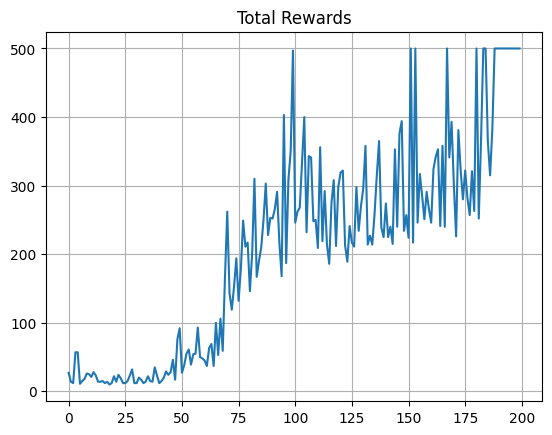

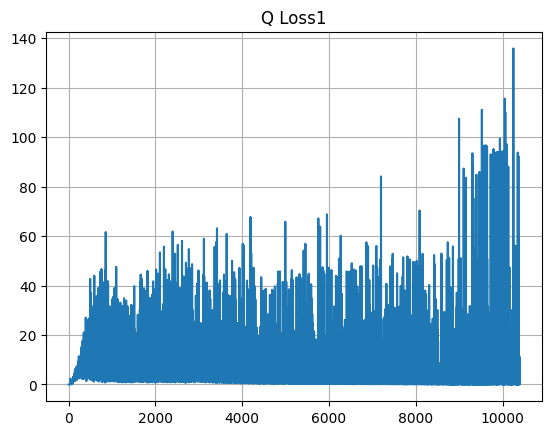

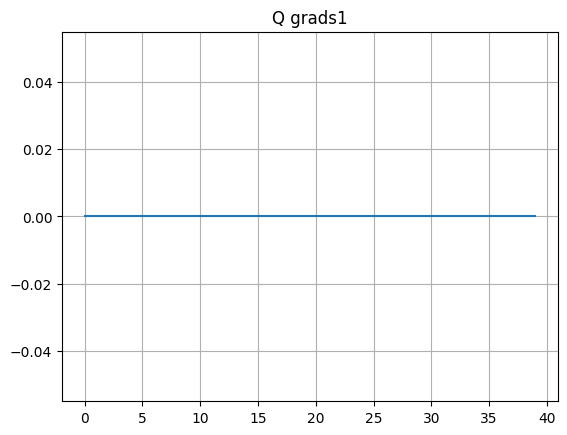

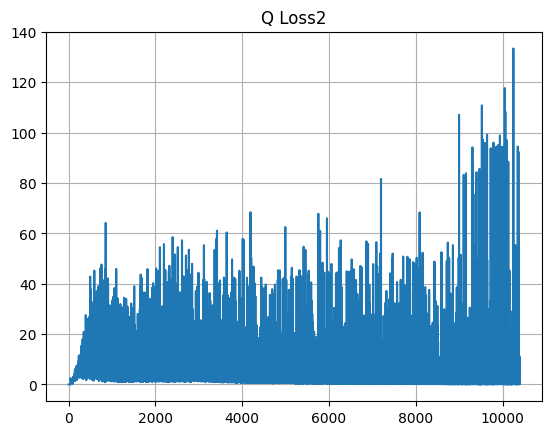

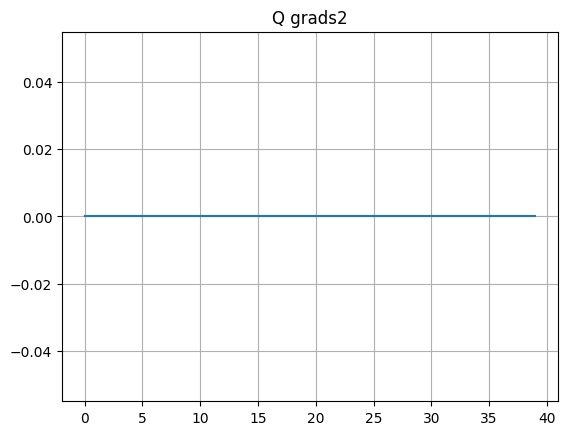

In [2]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = SAC_discrete(state_dim, action_dim)

episode_n = 200

total_rewards = []
loss1 = []
grads1 = []
loss2 = []
grads2 = []
counter = 0
for episode in range(episode_n):

    total_reward = 0
    state, info = env.reset()
    
    for i in range(1000):
        action = agent.get_action(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        
        agent.add_five(state, action, reward, terminated or truncated, next_state)
        counter += 1

        if counter % 4 == 0:
            _mean_q1_loss, _mean_q2_loss, _mean_q1_grads, _mean_q2_grads = agent.fit()
            loss1.append(_mean_q1_loss)
            grads1.append(_mean_q1_grads)
            loss2.append(_mean_q2_loss)
            grads2.append(_mean_q2_grads)
    
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    
        
    total_rewards.append(total_reward)
    if episode % 2 == 0:
        print(np.mean(total_rewards[-10:]))
    

plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()
plt.plot(loss1)
plt.title('Q Loss1')
plt.grid()
plt.show()
plt.plot(grads1)
plt.title('Q grads1')
plt.grid()
plt.show()
plt.plot(loss2)
plt.title('Q Loss2')
plt.grid()
plt.show()
plt.plot(grads2)
plt.title('Q grads2')
plt.grid()
plt.show()

In [32]:
import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import Normal
from torch.distributions.categorical import Categorical
from torch.distributions import RelaxedOneHotCategorical
from torch.nn import KLDivLoss

# torch.manual_seed(42)

class SAC_discrete_for_lunar(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1.0, tau=0.8, 
                 batch_size=128, pi_lr=1e-3, q_lr=1e-3, a_lr=1e-5, period=10):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim), nn.LogSoftmax(dim=1))
        self.pi_model.name = "policy"

        self.q1_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim))
        self.q1_model.name = "q1"

        self.q2_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(), 
                                      nn.Linear(64, action_dim))
        self.q2_model.name = "q2"

        self.q1_layers_list = [self.q1_model[0], self.q1_model[2], self.q1_model[4]]
        self.q2_layers_list = [self.q2_model[0], self.q2_model[2], self.q2_model[4]]
        self.gamma = gamma
        # self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []
        self.period = period
        self.counter = 1
        self.step = 1
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epoch_n = 1
        self.q1_grads = []
        self.q2_grads = []
        

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        # self.q_optimizer = torch.optim.Adam(self.q_model.parameters(), q_lr)
        # self.q_target_model = deepcopy(self.q_model)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

        self.target_entropy = 0.98 * -np.log(1 / self.action_dim)
        self.log_alpha = torch.tensor(np.log(alpha), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=a_lr)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        log_probs = self.pi_model(state)
        if self.step % 300 == 0:
            print(f'probs: {torch.exp(log_probs)}')
            self.step += 1
            print(f'alpha: {round(self.alpha.detach().numpy().reshape(-1)[0] , 2)}')
        action = np.random.choice(np.arange(self.action_dim), p=torch.exp(log_probs).squeeze().detach().numpy())
        return action

    def add_five(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])
    # дать накопить сначала около 10к значений в буфере а потом уже начинать обучаться
    def fit(self):
        if len(self.memory) >= self.batch_size + 100:
            mean_q1_loss = []
            mean_q2_loss = []
            for i in range(self.epoch_n):
                batch = random.sample(self.memory, self.batch_size)
            
                states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
                rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)
                # print(next_states)
                
                next_log_probs = self.pi_model(next_states)
                # print(next_probs.shape)
                next_probs = torch.exp(next_log_probs)
                # print(next_log_probs.shape)
                
                # print(next_actions)
                next_q1_values = self.q1_target_model(next_states)
                next_q2_values = self.q2_target_model(next_states)
                next_min_q_values = torch.min(next_q1_values, next_q2_values)
                targets = rewards + self.gamma * (1 - dones) * torch.sum((next_min_q_values - self.alpha * next_log_probs) * next_probs, dim=1).unsqueeze(1)
                # targets = rewards + self.gamma * (1 - dones) * torch.max(next_min_q_values, dim=1).values
                # print((next_min_q_values - self.alpha * next_log_probs).shape)
                # print(targets[0])
                actions = actions.unsqueeze(1)
                actions = torch.tensor(actions, dtype=torch.long)
                # print(self.q1_model(states).gather(1, actions)[0])
                # q_loss = torch.mean((self.q_model(states)[torch.arange(next_states.shape[0]), actions] - targets.detach()) ** 2)
                q1_loss = torch.mean((self.q1_model(states).gather(1, actions) - targets.detach()) ** 2)
                q2_loss = torch.mean((self.q2_model(states).gather(1, actions) - targets.detach()) ** 2)
                if self.step % 300 == 0:
                    print(f'q loss: {q1_loss.data.numpy()}')
                # print(f'q_loss=\n {q_loss.data.numpy()}')
                mean_q1_loss.append(q1_loss.data.numpy())
                mean_q2_loss.append(q2_loss.data.numpy())
    
                self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
                self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

                if i % 2 == 0:
                    log_probs = self.pi_model(states)
                    
                    q1_values = self.q1_model(states)
                    q2_values = self.q2_model(states)
                    min_q_values = torch.min(q1_values, q2_values)
    
                    pi_loss = torch.mean(torch.sum((self.alpha * log_probs - (min_q_values).detach()) * torch.exp(log_probs), dim=1) )
                    if self.step % 300 == 0:
                        print(f'pi loss: {pi_loss.data.numpy()}')
    
                    self.update_model(pi_loss, self.pi_optimizer, self.pi_model)

                    alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
                    alpha_loss.backward()
                    self.alpha_optimiser.step()
                    self.alpha = self.log_alpha.exp()
                    self.alpha_optimiser.zero_grad()
                
                self.counter += 1
                
            self.step += 1

            # for graphics
            mean_q1_grads = np.mean(self.q1_grads)
            self.q1_grads = []
            mean_q2_grads = np.mean(self.q2_grads)
            self.q2_grads = []
            return np.mean(mean_q1_loss), np.mean(mean_q2_loss), mean_q1_grads, mean_q2_grads
        else:
            return 0, 0, 0, 0
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        if model.name == "policy":
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        else:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()
        
        if model != None and target_model != None and self.counter % self.period == 0:
            for param, target_param in zip(model.parameters(), target_model.parameters()):
                new_target_param = (1 - self.tau) * target_param + self.tau * param
                target_param.data.copy_(new_target_param)
                

-125.63761473120749
-124.96629523190167


/tmp/ipykernel_10473/3285244228.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.long)


-171.95003666644132
probs: tensor([[0.1134, 0.0830, 0.7140, 0.0896]], grad_fn=<ExpBackward0>)
alpha: 1.0
probs: tensor([[0.4744, 0.1812, 0.1813, 0.1631]], grad_fn=<ExpBackward0>)
alpha: 1.0
-216.1755868260465
probs: tensor([[0.1389, 0.0497, 0.0913, 0.7201]], grad_fn=<ExpBackward0>)
alpha: 1.0
-209.41862150234704
probs: tensor([[0.1122, 0.1880, 0.5462, 0.1536]], grad_fn=<ExpBackward0>)
alpha: 1.0
-193.98354557585156
probs: tensor([[0.1558, 0.6627, 0.1758, 0.0056]], grad_fn=<ExpBackward0>)
alpha: 0.99
probs: tensor([[0.2195, 0.1123, 0.3861, 0.2821]], grad_fn=<ExpBackward0>)
alpha: 0.99
probs: tensor([[0.2466, 0.1284, 0.5218, 0.1032]], grad_fn=<ExpBackward0>)
alpha: 0.99
probs: tensor([[0.1074, 0.1828, 0.5708, 0.1390]], grad_fn=<ExpBackward0>)
alpha: 0.98
-182.45436787621207
probs: tensor([[0.2400, 0.2874, 0.4134, 0.0592]], grad_fn=<ExpBackward0>)
alpha: 0.98
probs: tensor([[0.1175, 0.0558, 0.4161, 0.4106]], grad_fn=<ExpBackward0>)
alpha: 0.98
probs: tensor([[0.1449, 0.1969, 0.5912, 0.067

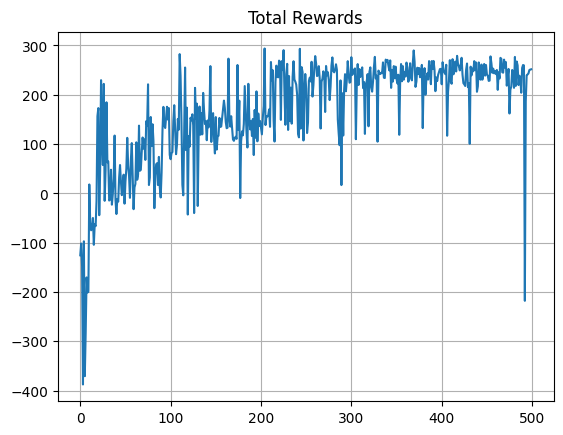

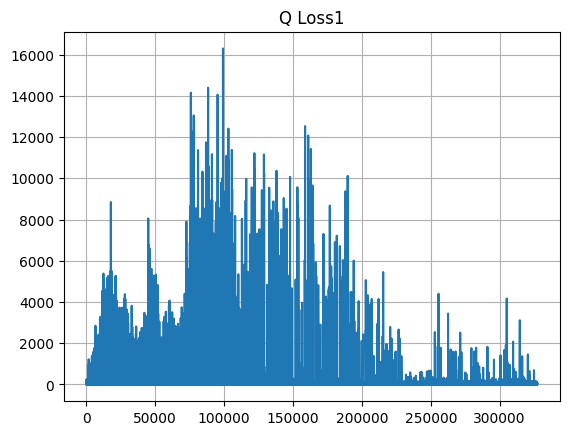

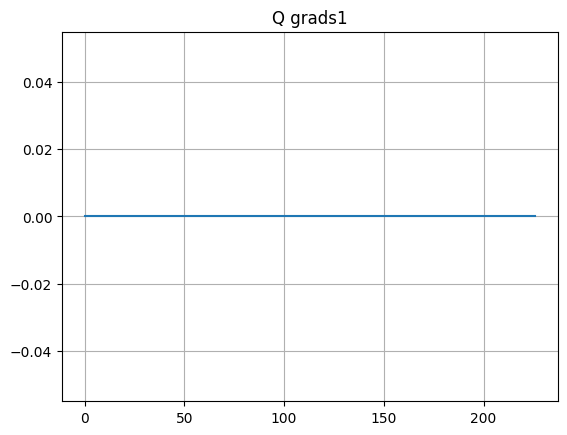

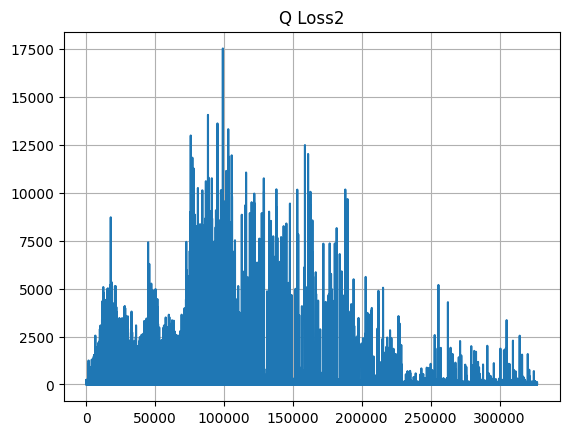

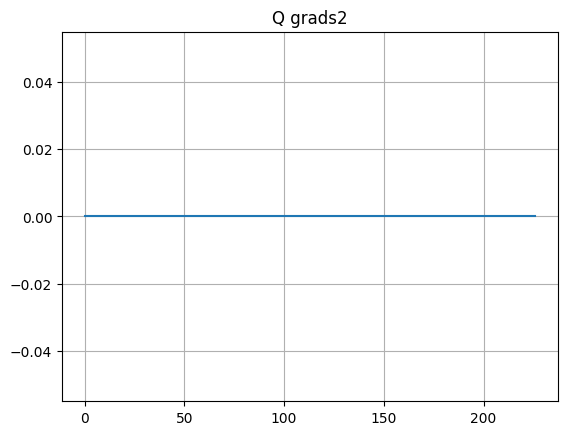

In [33]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = SAC_discrete_for_lunar(state_dim, action_dim)

episode_n = 500

total_rewards = []
loss1 = []
grads1 = []
loss2 = []
grads2 = []
counter = 0
for episode in range(episode_n):

    total_reward = 0
    state, info = env.reset()
    
    for i in range(1000):
        action = agent.get_action(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        
        agent.add_five(state, action, reward, terminated or truncated, next_state)
        counter += 1

        if counter % 1 == 0:
            _mean_q1_loss, _mean_q2_loss, _mean_q1_grads, _mean_q2_grads = agent.fit()
            loss1.append(_mean_q1_loss)
            grads1.append(_mean_q1_grads)
            loss2.append(_mean_q2_loss)
            grads2.append(_mean_q2_grads)
    
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    
        
    total_rewards.append(total_reward)
    if episode % 2 == 0:
        print(np.mean(total_rewards[-10:]))
    

plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()
plt.plot(loss1)
plt.title('Q Loss1')
plt.grid()
plt.show()
plt.plot(grads1)
plt.title('Q grads1')
plt.grid()
plt.show()
plt.plot(loss2)
plt.title('Q Loss2')
plt.grid()
plt.show()
plt.plot(grads2)
plt.title('Q grads2')
plt.grid()
plt.show()

In [10]:
s = nn.LogSoftmax(dim=1)
torch.exp(s(torch.tensor([[-2.0, 1.0]])))

tensor([[0.0474, 0.9526]])

In [34]:
env = gym.make('LunarLander-v2', render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


total_reward = 0
state, info = env.reset()

for i in range(1000):
    action = agent.get_action(state)
    
    next_state, reward, terminated, truncated, info = env.step(action)

    env.render()

    total_reward += reward
    state = next_state

    if terminated or truncated:
        break

print(total_reward)

/home/artem/atari_games/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


257.99014797953294
